## Vestibular Model Steering

This notebook demonstrates the effects of steering on the vestibular-adapted predictive coding model. In this model, you'll load a vestibular predictive coding model and its linear or nonlinear location probes. Then, various amounts of speed are applied to the model, and the change in predicted location is measured.

In [1]:
import os
import re
import sys
import random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor, Normalize
from PIL import Image

from sklearn.preprocessing import StandardScaler
from pickle import load
from tqdm import tqdm

from predictive_coding.src import PredictiveCoder, VestibularCoder, PositionProbe
from predictive_coding.src.dataset import collate_fn, EnvironmentDataset
from predictive_coding.src.trainer import Trainer


/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/mag/miniconda3/envs/predictive-code/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load predictive coder and probes

In [2]:
from pathlib import Path

experiment = '0.9-0.9'
num_actions = experiment.count('-') + 1
device = 'cuda:1'
experiment_name = f'predictive-coding-{experiment}-new-vest'

current_file_path = Path().resolve()
weights_path = current_file_path.parent / "predictive_coding" / "weights" / experiment_name / "best.ckpt"

model = VestibularCoder(in_channels=3, out_channels=3, layers=[2, 2, 2, 2], 
                        seq_len=20, num_actions=num_actions)
model.load_state_dict(torch.load(weights_path))
model.eval()
model = model.to(device)

Positional decoding was done in the original model with nonlinear probes. We also have a linear SVM (mirroring methods from primate place cell studies) but the SVMs displayed worse localization performance and no change in steering performance.

In [3]:
use_linear_probe = False # TODO, you just need a few more if statements during evaluation
residual = 2

weights_path = current_file_path.parent / "predictive_coding" / "weights" / experiment_name / f'position-decoder-residual-{residual}-nonlinear-multiview.pth'

position_decoder = PositionProbe()
position_decoder.load_state_dict(torch.load(weights_path))
position_decoder.eval()


PositionProbe(
  (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=16384, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=2, bias=True)
)

Minecraft uses a X, Y, Z coordinate system. The most straightforward way to test the impact of steering is to point the model in a certain direction, apply speed, get a set of latents for the prediction, and see if the decoded location indicates an increase in the correct direction. 
- 0 degrees should lead to an increase along the Z axis
- 90 degrees should lead to an increase along the X axis

You can adjust which_view and see the same result for either direction.

In [4]:
# index 0 is 0 degrees; index 12 is 90 degrees
which_view = 0

mean_vals = [121.6697 / 255, 149.3242 / 255, 154.9510 / 255]
std_vals  = [40.7521 / 255,  47.7267 / 255, 103.2739 / 255]
normalize = Normalize(mean_vals, std_vals)

pics_path = current_file_path.parent / "datasets/small-world-pcs"

folds = [p for p in pics_path.glob('*') if p.is_dir()]
images = torch.empty(len(folds), 20, 3, 64, 64)
actions = torch.zeros((len(folds), 20, 2))
positions = torch.zeros(len(folds), 2)

for idx, fold in enumerate(folds):
    x, y = re.findall(r"(.*)_(.*)", fold.name)[0]  # Use .name to extract directory name
    positions[idx] = torch.from_numpy(np.load(fold / "state.npz")['arr_0'])[which_view, :2]

    image = Image.open(fold / f"{which_view}.png")
    image = normalize(ToTensor()(image))
    image = torch.unsqueeze(image, 0)  # Add a batch dimension
    images[idx] = torch.tile(image, dims=(20, 1, 1, 1))  # Tile to create a batch of 20 identical images 
    # tiling mainly exists if you want to examine the effect of adding speed across multiple steps
    # or if you're using a positional decoder trained on the whole sequence
    


Tiling the images in the above code mainly exists for if you'd like to examine the effect of adding speed across multiple steps, or if you're using a positional decoder trained on the whole sequence. I thought it might be possible that location is more generally encoded across a sequence, but I didn't find this to change the final results.


In [12]:
small_env = True
if small_env:
    x_mean, x_std = 128.4991, 4.8996
    y_mean, y_std = 205.5003, 4.8996
else:
    x_mean, x_std = -0.0617, 11.8028
    y_mean, y_std = -0.0456, 18.4132

def show_traj(imgs):
    """
    Utility to show a grid of images (normalized).
    Expects imgs to be a 4D tensor [T, C, H, W].
    """
    def denorm(x):
        x = x.cpu().numpy().transpose((1, 2, 0))
        x = x * std_vals + mean_vals
        return np.clip(x, 0, 1)

    grid = torchvision.utils.make_grid(imgs, nrow=len(imgs))
    
    plt.figure(figsize=(20, 5))
    plt.imshow(denorm(grid))
    plt.axis('off')
    plt.show()

def denorm_guess(guess):
    """
    Undo the decoder's normalization on position output.
    Hardcoded values are from the standard environment.
    """
    guess[0] = guess[0] * x_std + x_mean
    guess[1] = guess[1] * y_std + y_mean
    return guess


### Visualize a sample and predicted next frame and location

Random sample index: 179
Actual position: tensor([133.5000, 210.5000])


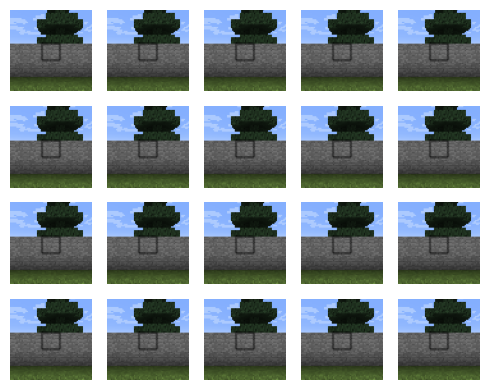

In [13]:
def show_traj(imgs):
    """
    Utility to show a grid of images (normalized).
    Expects imgs to be a 4D tensor [T, C, H, W].
    """
    def denorm(x):
        x = x.cpu().numpy().transpose((1, 2, 0))
        x = x * std_vals + mean_vals
        return np.clip(x, 0, 1)

    
    num_imgs = imgs.shape[0]
    cols = min(num_imgs, 5) 
    rows = (num_imgs + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    axes = axes.flatten() 

    for i, img in enumerate(imgs):
        ax = axes[i]
        ax.imshow(denorm(img))
        ax.axis("off")
    for ax in axes[num_imgs:]: 
        ax.axis("off")

    plt.tight_layout()
    plt.show()

def denorm_guess(guess):
    """
    Undo the decoder's normalization on position output.
    Hardcoded values are from the standard environment.
    """
    guess[0] = guess[0] * x_std + x_mean
    guess[1] = guess[1] * y_std + y_mean
    return guess


idx = random.randint(0, positions.shape[0] - 1)
image_set = images[idx]       # [T, C, H, W]
action_set = actions[idx]     # [T, 2]
position  = positions[idx]    # [3]

print("Random sample index:", idx)
print("Actual position:", position)

show_traj(image_set)


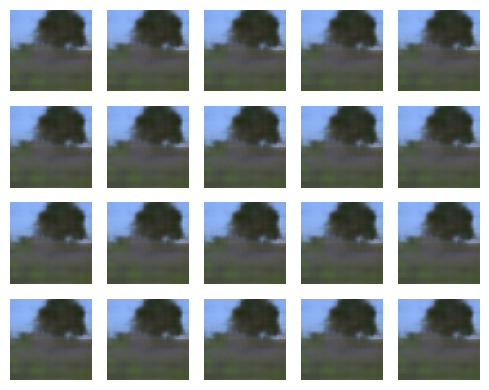

Predicted position: tensor([128.4595, 205.7142])
Position Error: 6.950615882873535


In [14]:
batched_image_set = torch.unsqueeze(image_set, 0).to(device)
batched_action_set = torch.unsqueeze(action_set, 0).to(device)

with torch.no_grad():
    preds = model(batched_image_set, batched_action_set)
    preds = preds.cpu()

show_traj(preds[0])

latents = model.get_latents(batched_image_set, 
                            actions=batched_action_set,
                            which=residual).detach().cpu()[:, -1]

with torch.no_grad():
    guessed_pos = position_decoder(latents)

pred = denorm_guess(guessed_pos[0])
print("Predicted position:", pred)
print("Position Error:", torch.linalg.norm(pred - position[:2], dim=0).item())

### Visualize the effect of a velocity increase on a prediction

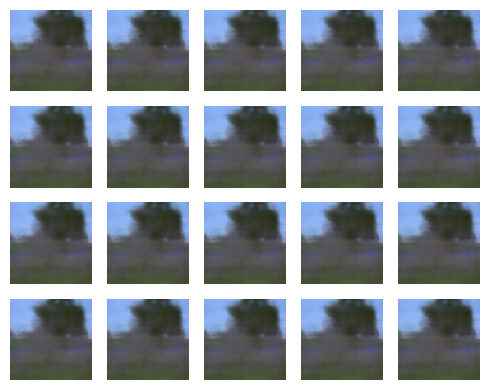

Tampered predicted position: tensor([127.2998, 203.8858])


In [15]:
tampered_action_set = batched_action_set.clone()
tampered_action_set[:, :, 0] += 3 

with torch.no_grad():
    preds_tampered = model(batched_image_set, tampered_action_set)
    preds_tampered = preds_tampered.cpu()

show_traj(preds_tampered[0])

latents_tampered = model.get_latents(batched_image_set, 
                                     actions=tampered_action_set, 
                                     which=residual).cpu()[:, -1]

with torch.no_grad():
    guessed_pos_tampered = position_decoder(latents_tampered)
tampered_pred = denorm_guess(guessed_pos_tampered[0])

print("Tampered predicted position:", tampered_pred)

### Large-scale offset analysis

Now we compare the average change in predicted position when velocity has been applied to the first step in the sequence. 

You can also add speed at every step in the sequence and decode location from the last predicted latent to see if this signal is integrated over the sequence. However I did not find that this made a difference.

In [16]:
trials = 100
speed_additions = 10
predicted_change = np.zeros((speed_additions, trials, 2))

for speed in tqdm(range(speed_additions)):
    for trial in range(trials):
        image_set_trial = torch.unsqueeze(images[trial], 0).to(device)
        action_set_trial = torch.unsqueeze(actions[trial], 0).to(device)

        latents_base = model.get_latents(image_set_trial,
                                         action_set_trial,
                                         which=residual).cpu()[:, -1]
        
        tampered_actions = action_set_trial.clone()
        tampered_actions[:, :, 0] += (speed + 1)
        latents_tamp = model.get_latents(image_set_trial,
                                         tampered_actions,
                                         which=residual).cpu()[:, -1]
        
        with torch.no_grad():
            pred_base = denorm_guess(position_decoder(latents_base).numpy()[0])
            pred_tamp = denorm_guess(position_decoder(latents_tamp).numpy()[0])
        
        predicted_change[speed, trial, :] = pred_tamp - pred_base

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.90s/it]


Because we're facing 0 degrees in the Minecraft environment in this example, an increase in velocity with no turning signal should lead to an increase along the Z axis, but we don't see that reflected in our positional decoder.

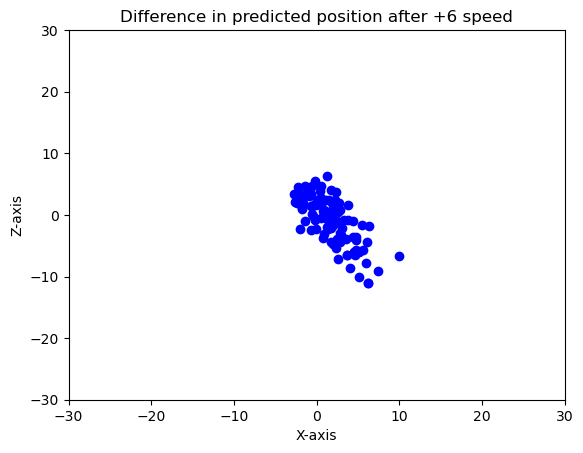

In [19]:
speed = 5  # example speed addition
x_vals = predicted_change[speed, :, 0]
y_vals = predicted_change[speed, :, 1]

plt.plot(x_vals, y_vals, 'bo')
ax = plt.gca()
ax.set_xlim([-30, 30])
ax.set_ylim([-30, 30])
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.title(f"Difference in predicted position after +{speed+1} speed")
plt.show()

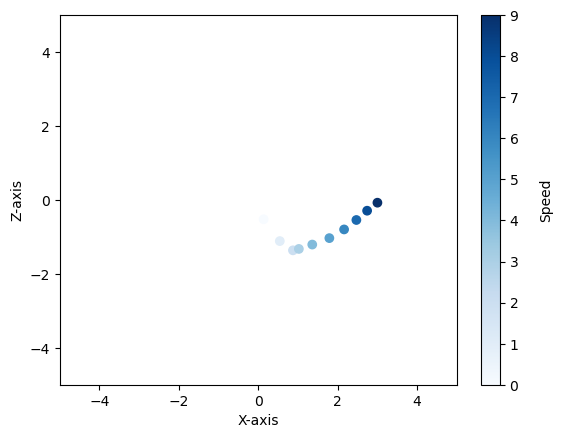

In [20]:
# Shift in predicted position

x_means = [np.mean(predicted_change[o, :, 0]) for o in range(speed_additions)]
z_means = [np.mean(predicted_change[o, :, 1]) for o in range(speed_additions)]
colors = np.arange(len(x_means))

scatter = plt.scatter(x_means, z_means, c=colors, cmap='Blues')
cbar = plt.colorbar(scatter)
cbar.set_label('Speed', rotation=90, labelpad=15)

ax = plt.gca()
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
plt.xlabel('X-axis')
plt.ylabel('Z-axis')

#if which_view == 0:
#plt.savefig(f'{experiment}-nonlinear-probe-facing-0.png', dpi=300, bbox_inches='tight')
#else:
#plt.savefig(f'{experiment}-nonlinear-probe-facing-90.png', dpi=300, bbox_inches='tight')
plt.show()

## Things I wish I had done and might still do:
- Train an RNN to do path integration as in Cueva and Wei 2018, then demonstrate a positive example of this steering test
- Try out this test but with head direction adjustments instead of velocity adjustments. 